In [1]:
# https://www.kaggle.com/uciml/iris

import numpy as np # linear algebra
from sklearn.model_selection import GridSearchCV
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

print('Done')

Done


# Introductory Materials



In [2]:
DATA = pd.read_csv("input/Iris.csv")
DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


# Data quick preparation


In [3]:
Ids = DATA.Id
DATA.drop('Id', axis = 'columns', inplace=True)
DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB



# Exploring the Data, planning the preprocessing


## Features Overview


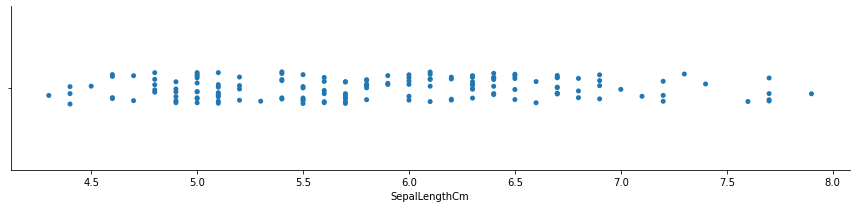

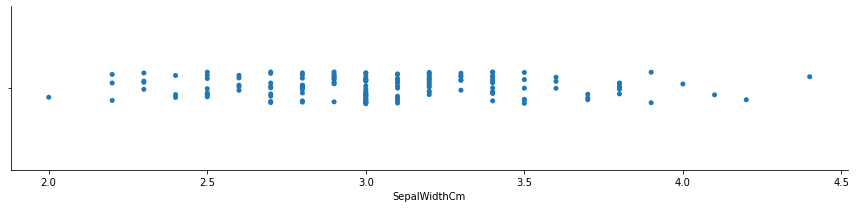

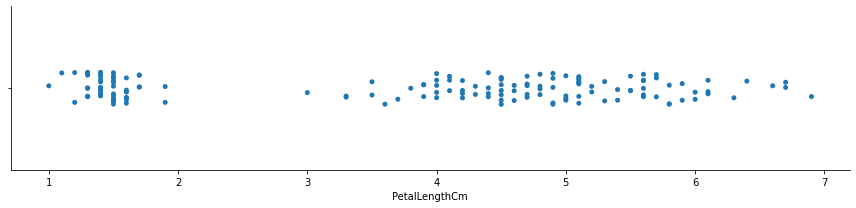

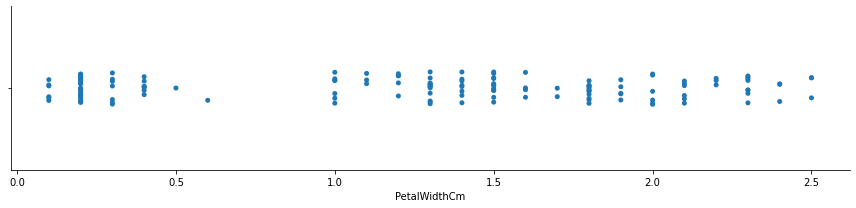

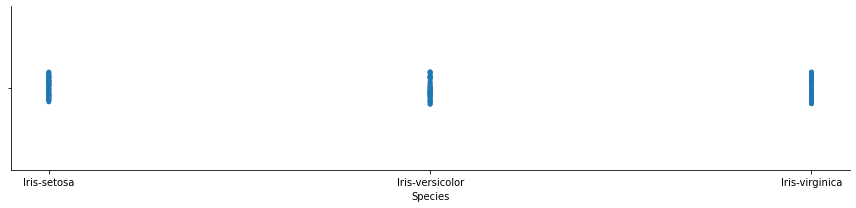

In [4]:
from libs.simpleplotter import simple_features_overview
simple_features_overview(DATA)

# Correlations between data

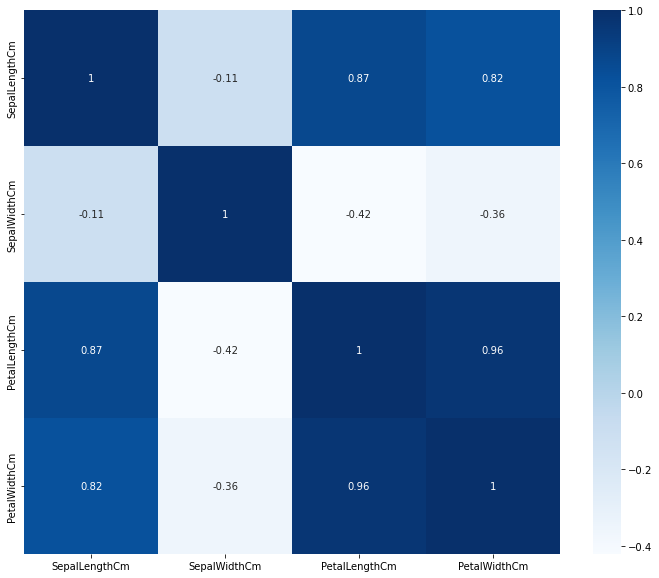

In [5]:
# Heatmap
from libs.simpleplotter import simple_heatmap
simple_heatmap(DATA)

##

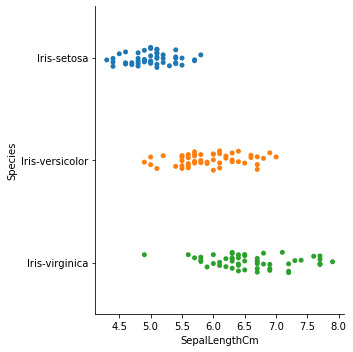

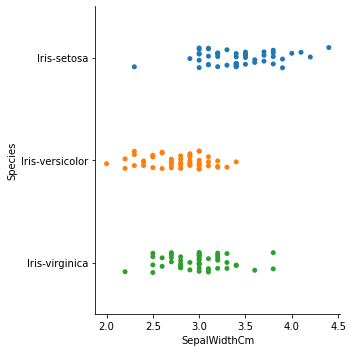

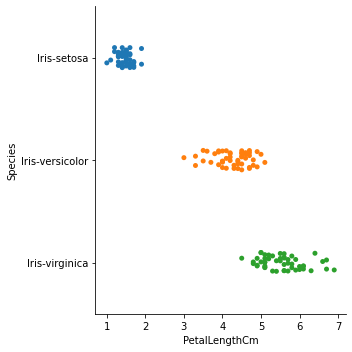

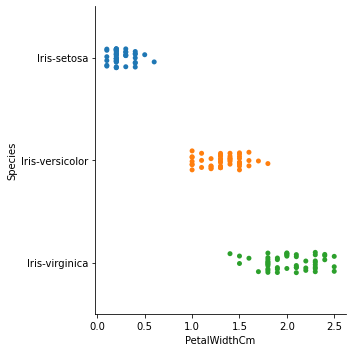

In [6]:
# sns.catplot(x="SepalLengthCm",y="Species",data=DATA)
from libs.simpleplotter import simple_correlations
simple_correlations(DATA, "Species")


In [7]:
DATA.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## Missing, Categorical & Not Useful Data


In [8]:
DATA.isnull().sum()

SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

In [9]:
DATA.describe(include='object')

,Species
count,150
unique,3
top,Iris-setosa
freq,50



# Data Processing


In [10]:
# Let's run the preprocessing on both train and test data

PROCESSED = DATA.copy(deep=True)

# for the need of Receiver Operating Characteristic (ROC) diagram we need to convert strings to ints
PROCESSED.replace('Iris-setosa', 1, inplace=True)
PROCESSED.replace('Iris-versicolor', 2, inplace=True)
PROCESSED.replace('Iris-virginica', 3, inplace=True)

In [11]:
PROCESSED.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1



# Post-Processing Data Analysis


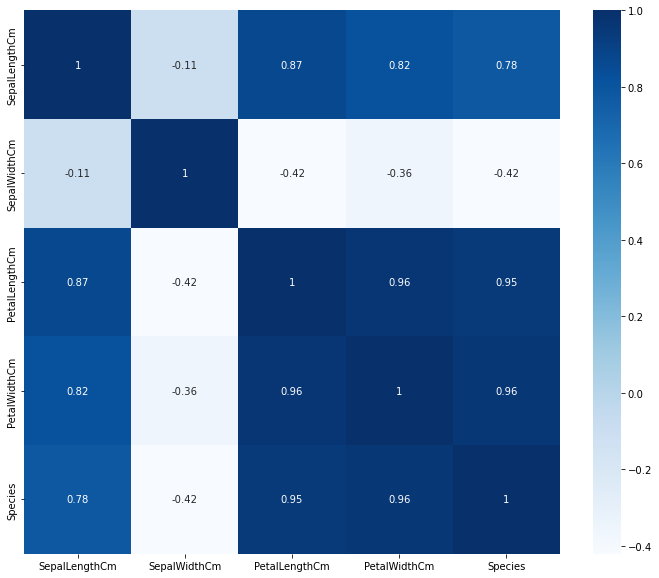

In [12]:
# Heatmap
from libs.simpleplotter import simple_heatmap
simple_heatmap(PROCESSED)

# Preparing for Model Training

## Separating target from features

In [13]:
y = PROCESSED['Species']
X = PROCESSED.drop(['Species'], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


## Splitting train data into train & validation data
as we can see the number of records in train data is lowered

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 137 to 47
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  120 non-null    float64
 1   SepalWidthCm   120 non-null    float64
 2   PetalLengthCm  120 non-null    float64
 3   PetalWidthCm   120 non-null    float64
dtypes: float64(4)
memory usage: 4.7 KB


In [15]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 114 to 26
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  30 non-null     float64
 1   SepalWidthCm   30 non-null     float64
 2   PetalLengthCm  30 non-null     float64
 3   PetalWidthCm   30 non-null     float64
dtypes: float64(4)
memory usage: 1.2 KB


# Models Training & Hyper-params Tuning for Different Classification Models


In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from libs.simple_processing import get_model_name, print_scores
from sklearn.linear_model import LinearRegression

params = [
    {
        'model': KNeighborsClassifier(),
        'hyperparams': {
            'n_neighbors': range(16, 20, 1),
            'n_jobs': range(4, 5, 1)
        }
    },
    # {
    #     'model': LinearRegression(),
    #     'hyperparams': {
    #     }
    # },
    {
        'model': DecisionTreeClassifier(random_state=0),
        'hyperparams': {
            'max_depth': [1, 2, 3, 4, 5],
            'max_leaf_nodes': range(2, 7, 1)
        }
    },
    {
        'model': RandomForestClassifier(n_jobs=4, max_features="auto", bootstrap=False),
        'hyperparams': {
            'criterion' :['gini', 'entropy'],
            'n_estimators': range(100, 300, 50),
            'n_jobs': range(4, 5, 1),
            'max_depth': range(6, 9, 1)
        }
    },
    {
        'model': GradientBoostingClassifier(random_state=0, max_features="auto"),
        'hyperparams': {
            'n_estimators': range(5, 15, 1),
            'learning_rate': np.arange(0.01, 0.1, 0.01),
            'max_depth': range(1, 5, 1)
        }
    }
]

grid_model = {}

# also tried to use cv=4 and 6-15 but it made results worse
for p in params:
    print('> Model:', get_model_name(p['model']))
    grid_model = GridSearchCV(p['model'], p['hyperparams'], cv=2, n_jobs=-1, scoring='accuracy', verbose=1)
    grid_model.fit(X_train, y_train)
    y_pred = grid_model.predict(X_valid)
    # grid_model.best_score_
    print(grid_model.best_params_)
    print_scores(y_valid, y_pred)


print('Done.')

> Model: KNeighborsClassifier
Fitting 2 folds for each of 4 candidates, totalling 8 fits
{'n_jobs': 4, 'n_neighbors': 19}
Accuracy score:  1.0
Accuracy count:  30 / 30
Precision score:  1.0
Recall score:  1.0
F1 score:  1.0

> Model: LinearRegression
Fitting 2 folds for each of 1 candidates, totalling 2 fits
{}


/Users/kkepins-macwro/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/kkepins-macwro/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/kkepins-macwro/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/kkepins-macwro/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/kkepins-macwro/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/Users/kkepi

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

## And The Winner Is....


## Score
Accuracy score / Dokładność [(TP+TN) / (TP+TN+FP+FN)]: how many of the values were predicted correctly?
Accuracy count: number of correct predictions
Precision score / Precyzja [TP / (TP+FP)]: how many passengers that the model thought survived actually did survive?
Recall score / Pełność [TP / (TP+FN]: how many of the actual survivors the model correctly predicted?
(also known as true positive rate / wskaźnik skuteczności - ryzyko niepoprawnego oznaczenia ofiary wypadku)
F1 score [2(prec x rec) / (prec + rec)]: combination of the above precision and recall scores

In [ ]:
from libs.simple_processing import print_scores

model = KNeighborsClassifier(n_jobs=4, n_neighbors=19)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
print_scores(y_valid, y_pred)

In [17]:
## linear regression
# https://stats.stackexchange.com/questions/430341/linear-regression-for-multi-class-classification
clf_linear = LinearRegression().fit(X_train, y_train)
#print(f"score of logistic method: {clf_linear.score(X_test, y_test)}")
y2 = np.round(X_valid.dot(clf_linear.coef_.T)+clf_linear.intercept_)
y3 = np.round(clf_linear.predict(X_valid))
assert np.array_equal(y2,y3) == True
acc_linear = np.sum(y2 == y_valid)/y_valid.shape[0]
print(f"accuracy of linear method: {acc_linear}")

accuracy of linear method: 1.0


In [ ]:
from libs.simpleplotter import decision_tree
model = DecisionTreeClassifier(max_depth=6, random_state=0, max_leaf_nodes=6 )
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)

print_scores(y_valid, y_pred)
decision_tree(model, X_train)

In [ ]:
model = RandomForestClassifier(criterion='gini', max_depth=7, n_estimators=150, n_jobs=4, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
print_scores(y_valid, y_pred)

In [ ]:
model = GradientBoostingClassifier(learning_rate=0.01, max_depth=5, n_estimators=7)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
print_scores(y_valid, y_pred)

## Receiver Operating Characteristic (ROC)

In [ ]:
from libs.simpleplotter import simple_roc

simple_roc(y_valid, y_pred)

## Confusion Matrix / Macierz pomyłek

In [ ]:
from libs.simpleplotter import simple_confusion_matrix
conf_matrix = simple_confusion_matrix(y_valid, y_pred, model.classes_)

In [ ]:
print('TP:', conf_matrix[1][1])
print('TN:', conf_matrix[0][0])
print('FP:', conf_matrix[0][1])
print('FN:', conf_matrix[1][0])

## Which features became decision makers for the model?

In [ ]:
from libs.simpleplotter import feature_importance

feature_importance(model, X_train)

# Generating Model Predictions For Test Data & Saving the results for Kaggle Competition

In [ ]:
y_pred = model.predict(X)
output = pd.DataFrame({'Id': Ids, 'Species': y_pred})

print_scores(y, y_pred)
# output.to_csv('./submission.csv', index=False)
# SUBMISSION = pd.read_csv("./submission.csv")
# SUBMISSION